# Multilayer perceptron（MLP）

### 原理简介

多层感知机（MLP，Multilayer Perceptron）也叫人工神经网络（ANN，Artificial Neural Network），除了输入输出层，它中间可以有多个隐层，最简单的MLP只含一个隐层，即三层的结构，如下图：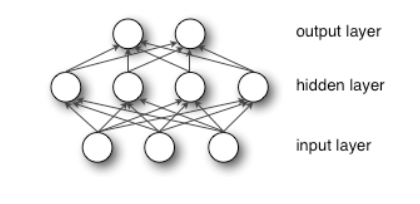

多层感知机层与层之间是全连接的（全连接的意思就是：上一层的任何一个神经元与下一层的所有神经元都有连接）。多层感知机最底层是输入层，中间是隐藏层，最后是输出层。比如输入是一个n维向量，就有n个神经元。

隐藏层的神经元怎么得来？首先它与输入层是全连接的，假设输入层用向量X表示，则隐藏层的输出就是
f(W1X+b1)，W1是权重（也叫连接系数），b1是偏置，函数f 可以是常用的sigmoid函数或者tanh函数：
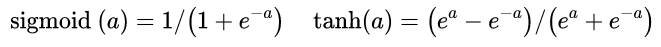

隐藏层到输出层可以看成是一个多类别的逻辑回归，也即softmax回归，所以输出层的输出就是softmax(W2X1+b2)，X1表示隐藏层的输出f(W1X+b1)。
三层的MLP用公式总结起来就是，函数G是softmax<br>
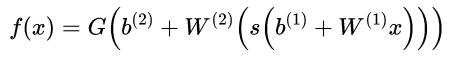

怎么确定这些参数？求解最佳的参数是一个最优化问题，解决最优化问题，最简单的就是梯度下降法了（SGD）：首先随机初始化所有参数，然后迭代地训练，不断地计算梯度和更新参数，直到满足某个条件为止（比如误差足够小、迭代次数足够多时）。这个过程涉及到代价函数、规则化（Regularization）、学习速率（learning rate）、梯度计算等.


隐藏层的输入即input，输出即隐藏层的神经元个数。输入层与隐藏层是全连接的。
假设输入是n_in维的向量（也可以说时n_in个神经元），隐藏层有n_out个神经元，则因为是全连接，
一共有n_in*n_out个权重，故W大小时(n_in,n_out),n_in行n_out列，每一列对应隐藏层的每一个神经元的连接权重。
b是偏置，隐藏层有n_out个神经元，故b是n_out维向量
W的初始化用随机数生成器，numpy.random.RandomState。



PS：参考反向传播介绍<br>https://www.cnblogs.com/charlotte77/p/5629865.html

### 1. 搭建神经网络基本流程
定义添加神经层的函数
* 1.训练的数据
* 2.定义节点准备接收数据
* 3.定义神经层：隐藏层和预测层
* 4.定义 loss 表达式
* 5.选择 optimizer 使 loss 达到最小
* 然后对所有变量进行初始化，通过 sess.run optimizer，迭代 1000 次进行学习：
<br><br>
#### build neural network see this link:<br>
https://www.jianshu.com/p/e112012a4b2d


In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import csv
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
#=============parameters definition=============#
# embedding_size: the length of the hidden vector for both user and item
emdedding_size_mlp = 20

# batch_size: the number of cases put into our model for one term
batch_size = 100

# num_epoch: the total round we train our model
num_epoch = 100

# learing_rate: the variable chaging speed for our optimizer
learning_rate = 0.001


#### 上面的各个参数 ---- 详见此链接：
基础概念：softmax， batch，min-batch，iterations，epoch，SGD
<br>https://blog.csdn.net/chancein007/article/details/73822955
* batch_size<br>
1.这个模型用的是批梯度下降法（Mini-batches Learning）更新权重w。在一定范围内，一般来说 Batch_Size 越大，其确定的下降方向越准，引起训练震荡越小。
* Epoch<br>Epoch就是把训练数组全部训练完成的一个正向和反向计算的过程。比如，我们有1000个样本，batch size是500，其将会有2个Iterations。这两个Iteration完成一个Epoch

In [3]:
#==========Data reading and preprocessing========#

data = pd.read_csv('./dataset/ratings.csv')
data = data[['userId', 'movieId','rating']]
data=data.values#change datafame to array

#number of user,item 
n_users = int(max(data[:,0]))#610
n_items = int(max(data[:,1]))#193609
# split our whole data into train_data and test_data。
train_data, test_data = train_test_split(data, test_size = 0.1)
a=set(train_data[:,0])
b=len(a)
c=set(test_data[:,0])
d=len(c)
b,d


(610, 589)

## Model Definition<br>


### Initialize Part
* **tf.placeholder**，定义节点准备接收数据

* 用 **tf.Variable** 定义变量，与python不同的是，必须先定义它是一个变量，它才是一个变量，初始值为0，构造一个(n_users+1) 乘以 embedding_size的矩阵，作为embeddings容器，意思为有(n_users+1)个容量为embedding_size的向量，每个向量代表一个user，每个向量的中的分量的值都在0到0.3之间随机分布
* keep_prob: 这个东西在后面的**tf.nn.dropout**用到，设置神经元被选中的概率,在初始化时keep_prob是一个占位符,  keep_prob = tf.placeholder(tf.float32) 。tensorflow在run时设置keep_prob具体的值，例如keep_prob: 0.5

In [4]:
#we define our placeholders for inputs our data.
#keep_prob is for the drop_out in the full_connect layer.
#user_id 是输入，在后面session()那里输入，一列user_id, item_id一样
user_id = tf.placeholder(tf.int32,[batch_size])#shape=(100,),100个节点
item_id = tf.placeholder(tf.int32,[batch_size])
rate = tf.placeholder(tf.float32,[batch_size,1])#rating列
keep_prob = tf.placeholder(tf.float32)

#We initialize our mlp user and item embedding matrix randomly here.
#As our user id sart from 1 so the shape is [n_users + 1, emdedding_size], the same for items.
user_embedding_mlp = tf.Variable(tf.random_uniform([n_users + 1, emdedding_size_mlp],0,0.3),trainable = True)#shape=(611, 20) dtype=float32
item_embedding_mlp = tf.Variable(tf.random_uniform([n_items + 1, emdedding_size_mlp],0,0.3),trainable = True)

## ---------------------MLP Part-------------------#


* 调用**tf.nn.embedding_lookup**，索引与train_dataset对应的向量，相当于用train_dataset作为一个id，去检索矩阵中与这个id对应的embedding
* **regularization**：在损失函数上加上正则项是防止过拟合的一个重要方法，详见https://blog.csdn.net/u012436149/article/details/70264257
* **tf.nn.dropout**是TensorFlow里面为了防止或减轻过拟合而使用的函数，必须设置概率keep_prob,并且keep_prob也是一个占位符,跟输入是一样的，详见：https://blog.csdn.net/huahuazhu/article/details/73649389
* **tf.nn.xw_plus_b()== tf.matmul()** 矩阵相乘
* **AdamOptimizer**： 自适应矩估计，如果一个随机变量 X 服从某个分布，X 的一阶矩是 E(X)，也就是样本平均值，X 的二阶矩就是 E(X^2)，也就是样本平方的平均值。Adam 算法根据损失函数对每个参数的梯度的一阶矩估计和二阶矩估计动态调整针对于每个参数的学习速率。TensorFlow提供的tf.train.AdamOptimizer可控制学习速度。Adam 也是基于梯度下降的方法，但是每次迭代参数的学习步长都有一个确定的范围，不会因为很大的梯度导致很大的学习步长，参数的值比较稳定。it does not require stationary objective, works with sparse gradients, naturally performs a form of step size annealing。AdamOptimizer通过使用动量（参数的移动平均数）来改善传统梯度下降，促进超参数动态调整。


In [6]:
#We use embedding_lookup to find out the item and user we are training or testing now for the mlp layer,
#both of them are with shape [bath_size, embedding_size_mlp].
#把user_id 一个array[,,,,](20个数值)代表
user_input_mlp = tf.nn.embedding_lookup(user_embedding_mlp, user_id)#shape=(100, 20) dtype=float32，user_id=100
item_input_mlp = tf.nn.embedding_lookup(item_embedding_mlp, item_id)

# Here is the regularization term using
regularizer = tf.contrib.layers.l2_regularizer(0.2)
reg_term = tf.contrib.layers.apply_regularization(regularizer,[user_input_mlp,item_input_mlp])

# We multiply the user hidden layer with the item hidden layer to get their combination with shape [bath_size, embedding_size_mlp]
fc_input = tf.concat([user_input_mlp,item_input_mlp],axis=1)#shape=(100, 40)

# Then we put the combined vector into our fc layers, with an out put fc_output.
# The shape of the fc_output is [batch_size, 1], which indicates the nonlinear connection between the item and the user.
w_1 = tf.Variable(tf.truncated_normal([2 * emdedding_size_mlp, 5], stddev=0.1))
b_1 = tf.Variable(tf.constant(0., shape=[5]))
l_1 = tf.nn.tanh(tf.nn.xw_plus_b(fc_input, w_1, b_1))
l_1_drop = tf.nn.dropout(l_1, keep_prob)


w_2 = tf.Variable(tf.truncated_normal([5, 1], stddev=0.1))
b_2 = tf.Variable(tf.constant(0., shape=[1]))
prediction = tf.nn.xw_plus_b(l_1_drop,w_2,b_2)#矩阵相乘,shape(100,1)


# We use mean_squared_error as the loss, and plus the regularization term.
loss = tf.losses.mean_squared_error(rate, prediction) + reg_term
train = tf.train.AdamOptimizer(learning_rate).minimize(loss)
print("--") 

--


In [ ]:
#main
with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        print('Start learning...')
        each_epoch_train_rmse_list=[]
        each_epoch_test_rmse_list=[]
        x_epoch=[]#后面作图用
        for epoch in range(100):#训练100回合
            train_loss = []
            #zip:将对象中对应的元素打包成一个个元组，然后返回由这些元组组成的对象，这样做的好处是节约了不少的内存。
            for start,end in zip(range(0,len(train_data), batch_size),range(batch_size,len(train_data),batch_size)):#100份100份的取
                tr_loss,_ = sess.run([loss, train], feed_dict={user_id : train_data[start:end,0], item_id : train_data[start:end,1], rate: train_data[start:end,2].reshape(batch_size,1), keep_prob: 0.5})       
                train_loss.append(tr_loss)
            rmse = []
            for start, end in zip(range(0, len(test_data), batch_size),range(batch_size, len(test_data), batch_size)):
                pred = sess.run(prediction, feed_dict={user_id : test_data[start:end,0], item_id : test_data[start:end,1], rate: test_data[start:end,2].reshape(batch_size,1), keep_prob: 1.0})
                pred = [[min(max(i[0],1),5)] for i in pred]#使得预测分数在1，5之间，小于1的=1，大于5的=5
                pred = np.array(pred)
                rmse.append((pred - test_data[start:end,2].reshape(batch_size,1))**2)
            
            Train_rmse=np.sqrt(np.mean(train_loss))
            Test_rmse= np.sqrt(np.mean(rmse))
            if epoch%5 == 0:
                print('epoch: ',format(epoch))
                print("Train_rmse: {:.3f}, Test_rmse: {:.3f}".format(Train_rmse, Test_rmse))
                #下面作图用的
                x_epoch.append(epoch)
                each_epoch_train_rmse_list.append(Train_rmse)
                each_epoch_test_rmse_list.append(Test_rmse)


        
        
         
        
        
        

Start learning...
epoch:  0
Train_rmse: 3.056, Test_rmse: 1.191
Train_rmse: 1.877, Test_rmse: 1.088
Train_rmse: 1.561, Test_rmse: 1.028
Train_rmse: 1.343, Test_rmse: 0.973
Train_rmse: 1.184, Test_rmse: 0.926
epoch:  5
Train_rmse: 1.067, Test_rmse: 0.907
Train_rmse: 1.001, Test_rmse: 0.900


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
print("--------train error-------------------")

plt.plot(x_epoch, each_epoch_train_rmse_list)
plt.xlabel('epoch')
plt.ylabel('rmse error')
plt.show()
print("--------test error-------------------")
plt.plot(x, each_epoch_test_rmse_list)
plt.xlabel('epoch')
plt.ylabel('rmse error')
plt.show()